In [16]:
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
import os
import mlflow

# Optimisations de TensorFlow sur macOS
os.environ["TF_METAL_DISABLE_RENDER_COMPOSITOR"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

warnings.filterwarnings("ignore")

# D√©finition du mod√®le VGG
image_resize = 224
my_VGG = Sequential()


In [3]:
import warnings
warnings.filterwarnings("ignore")  # Ignore les warnings pour √©viter les messages inutiles dans la console.

def get_train_test(base_path: str):  # D√©finition d'une fonction qui charge et pr√©pare les images √† partir d'un dossier.
    X = []  # Liste pour stocker les images.
    y = []  # Liste pour stocker les labels.

    label_map = {"NORMAL": 0, "PNEUMONIA": 1}  # Dictionnaire associant les labels aux classes num√©riques.

    for label in os.listdir(base_path):  # Parcours des dossiers pr√©sents dans le r√©pertoire de base.
        if label not in label_map:  # V√©rifie que le dossier correspond bien √† une classe attendue
            continue  # Si le label ne fait pas partie des classes d√©finies, il est ignor√©.

        label_path = os.path.join(base_path, label)  # Cr√©ation du chemin vers le dossier contenant les images.

        for file_name in os.listdir(label_path):  # Parcours de chaque fichier dans le dossier.
            file_path = os.path.join(label_path, file_name)  # Obtention du chemin complet de l'image.
            img = cv2.imread(file_path)  # Lecture de l'image avec OpenCV.
            if img is None:  # V√©rifie que l'image a bien √©t√© charg√©e.
                continue  # Ignore les fichiers qui ne sont pas des images valides.

            img = cv2.resize(img, (image_resize, image_resize), interpolation=cv2.INTER_CUBIC)  # Redimensionne l'image √† la taille souhait√©e.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertit l'image du format BGR (OpenCV) √† RGB (standard).
            img = img / 255.0  # Normalise les pixels entre 0 et 1 pour am√©liorer la stabilit√© du mod√®le.

            X.append(img)  # Ajoute l'image pr√©trait√©e √† la liste X.
            y.append(label_map[label])  # Ajoute le label correspondant √† la liste y.

    X = np.array(X).reshape(-1, image_resize, image_resize, 3)  # Convertit la liste en tableau NumPy avec la bonne forme (nombre d'images, hauteur, largeur, canaux).
    y = np.array(y).reshape(-1, 1)  # Convertit la liste de labels en tableau NumPy.

    return X, y  # Retourne les tableaux contenant les images et leurs labels.

# Chargement des donn√©es d'entra√Ænement et de test.
X_train, y_train = get_train_test("chest_xray/train")  # Charge les images pour l'entra√Ænement.
X_test, y_test = get_train_test("chest_xray/test")  # Charge les images pour le test.

## test sur le mod√©le VGG16

In [4]:
# D√©finition de la forme des images d'entr√©e (hauteur, largeur, canaux de couleur)
img_shape = (224, 224, 3)

# Chargement du mod√®le pr√©-entra√Æn√© VGG16 sans les couches de classification finales
# - `input_shape` : sp√©cifie la taille des images d'entr√©e
# - `include_top=False` : exclut les couches de classification du haut du mod√®le
# - `weights='imagenet'` : utilise les poids pr√©-entra√Æn√©s sur le dataset ImageNet
model_VGG16 = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')

# Affiche un r√©sum√© de l'architecture du mod√®le, y compris les couches et le nombre de param√®tres
model_VGG16.summary()

2025-05-26 14:59:29.789859: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-26 14:59:29.790247: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-26 14:59:29.790258: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-26 14:59:29.790541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 14:59:29.790579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)        ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv1 (Conv2D)           ‚îÇ (None, 224, 224, 64)   ‚îÇ         1,792 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv2 (Conv2D)           ‚îÇ (None, 224, 224, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_pool (MaxPooling2D)      ‚îÇ (None, 112, 112, 64)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv1 (Conv2D)           ‚îÇ (None, 112, 112, 128)  ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv2 (Conv2D)           ‚îÇ (None, 112, 112, 128)  ‚îÇ       147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_pool (MaxPooling2D)      ‚îÇ (None, 56, 56, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv1 (Conv2D)           ‚îÇ (None, 56, 56, 256)    ‚îÇ       295,168 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv2 (Conv2D)           ‚îÇ (None, 56, 56, 256)    ‚îÇ       590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv3 (Conv2D)           ‚îÇ (None, 56, 56, 256)    ‚îÇ       590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_pool (MaxPooling2D)      ‚îÇ (None, 28, 28, 256)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# adapter le mod√®le pour correspondre a nos besoins
model_VGG16.trainable = False

In [6]:
# Renvoie la sortie brute du mod√®le VGG16
# Cette sortie correspond au tenseur produit par la derni√®re couche du mod√®le
# pr√©-entra√Æn√© VGG16, sans les couches de classification finales (car include_top=False).
model_VGG16.output

<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_18>

In [7]:
# Modifier la couche de sorties
x = Flatten()(model_VGG16.output)  # Aplatissement des sorties du mod√®le VGG16
prediction = Dense(1, activation='sigmoid')(x)  # Couche de sortie avec activation sigmoid pour classification binaire

In [8]:
# Cr√©ation du mod√®le final en sp√©cifiant les entr√©es et sorties
# - `inputs=model_VGG16.input` : Utilise les entr√©es du mod√®le VGG16 pr√©-entra√Æn√©
# - `outputs=prediction` : D√©finit la sortie comme la couche personnalis√©e ajout√©e
model = Model(inputs=model_VGG16.input, outputs=prediction)

# Affiche un r√©sum√© de l'architecture du mod√®le, y compris les couches et le nombre de param√®tres
model.summary()

Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)        ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv1 (Conv2D)           ‚îÇ (None, 224, 224, 64)   ‚îÇ         1,792 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv2 (Conv2D)           ‚îÇ (None, 224, 224, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_pool (MaxPooling2D)      ‚îÇ (None, 112, 112, 64)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv1 (Conv2D)           ‚îÇ (None, 112, 112, 128)  ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv2 (Conv2D)           ‚îÇ (None, 112, 112, 128)  ‚îÇ       147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_pool (MaxPooling2D)      ‚îÇ (None, 56, 56, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv1 (Conv2D)           ‚îÇ (None, 56, 56, 256)    ‚îÇ       295,168 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv2 (Conv2D)           ‚îÇ (None, 56, 56, 256)    ‚îÇ       590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv3 (Conv2D)           ‚îÇ (None, 56, 56, 256)    ‚îÇ       590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_pool (MaxPooling2D)      ‚îÇ (None, 28, 28, 256)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Compilation du mod√®le
# - `loss='categorical_crossentropy'` : Fonction de perte utilis√©e pour des probl√®mes de classification multi-classes.
# - `optimizer='adam'` : Optimiseur adaptatif efficace pour la descente de gradient.
# - `metrics=['accuracy']` : M√©trique utilis√©e pour √©valuer la performance du mod√®le.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# G√©n√©rateur pour les donn√©es d'entra√Ænement avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels
    shear_range=0.2,  # Transformation de cisaillement
    zoom_range=0.2,  # Zoom al√©atoire
    horizontal_flip=True  # Inversion horizontale
)

# G√©n√©rateur pour les donn√©es de test (sans augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation uniquement

# Chargement des donn√©es d'entra√Ænement
training_set = train_datagen.flow_from_directory(
    "chest_xray/train",  # R√©pertoire des donn√©es d'entra√Ænement
    target_size=(224, 224),  # Redimensionnement des images
    batch_size=32,  # Taille des lots
    class_mode='binary'  # Classification binaire
)

# Chargement des donn√©es de test
test_set = test_datagen.flow_from_directory(
    "chest_xray/test",  # R√©pertoire des donn√©es de test
    target_size=(224, 224),  # Redimensionnement des images
    batch_size=32,  # Taille des lots
    class_mode='binary'  # Classification binaire
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Importation des biblioth√®ques n√©cessaires
import mlflow  # Biblioth√®que de suivi des exp√©riences de Machine Learning
import mlflow.keras  # Int√©gration de MLflow avec Keras
import matplotlib.pyplot as plt  # Pour la visualisation des r√©sultats
import numpy as np  # Op√©rations sur les matrices et tableaux
import tensorflow as tf  # Biblioth√®que principale de deep learning
from tensorflow.keras.models import Model  # Classe de mod√®les personnalis√©s
from tensorflow.keras.layers import Flatten, Dense, Dropout  # Couches utilis√©es pour construire le mod√®le

# Initialisation du suivi MLflow
mlflow.set_experiment("VGG16 Classifier Adaptatif")  # D√©finition du nom de l'exp√©rience MLflow

# D√©finition des hyperparam√®tres initiaux
epochs = 15  # Nombre total d'√©poques d'entra√Ænement
batch_size = 15  # Nombre d'√©chantillons utilis√©s par lot
dense_units = 128  # Nombre initial de neurones dans les couches denses
dropout_rate = 0.5  # Taux de dropout pour √©viter le sur-apprentissage
target_accuracy = 0.95  # Seuil de pr√©cision cible pour arr√™ter l'ajout de nouvelles couches

# D√©finition du mod√®le initial bas√© sur VGG16
base_model = model_VGG16  # Chargement du mod√®le pr√©-entra√Æn√© VGG16
base_model.trainable = False  # On g√®le les poids pour ne pas les modifier durant l'entra√Ænement

# Ajout de couches au mod√®le pr√©-entra√Æn√©
x = Flatten()(base_model.output)  # Transformation des donn√©es en un vecteur plat
x = Dense(dense_units, activation="relu")(x)  # Premi√®re couche dense avec activation ReLU
x = Dropout(dropout_rate)(x)  # Ajout d'un dropout pour limiter le sur-apprentissage
prediction = Dense(1, activation="sigmoid")(x)  # Couche de sortie pour une classification binaire
model = Model(inputs=base_model.input, outputs=prediction)  # Cr√©ation du mod√®le final

# Compilation du mod√®le avec la fonction de co√ªt et l'optimiseur
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# D√©marrage du suivi MLflow pour enregistrer les r√©sultats de l'exp√©rience
with mlflow.start_run(run_name=f"VGG16 Dynamique {epochs} epochs, {batch_size} batch"):

    for epoch in range(epochs):  # Boucle √† travers chaque √©poque d'entra√Ænement
        # Entra√Ænement du mod√®le pour une seule √©poque
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=1, batch_size=batch_size, verbose=1)

        # R√©cup√©rer les pr√©cisions obtenues
        val_accuracy = history.history["val_accuracy"][0]  # Pr√©cision sur les donn√©es de validation
        train_accuracy = history.history["accuracy"][0]  # Pr√©cision sur les donn√©es d'entra√Ænement

        # Enregistrement des m√©triques dans MLflow
        mlflow.log_metric(f"val_accuracy_epoch_{epoch+1}", val_accuracy)
        mlflow.log_metric(f"train_accuracy_epoch_{epoch+1}", train_accuracy)

        # V√©rification si la pr√©cision sur les donn√©es de validation est insuffisante
        if val_accuracy < target_accuracy:
            dense_units += 64  # Augmentation du nombre de neurones
            print(f"üîÅ Ajout de neurones √† l'√©poque {epoch+1}, total neurones : {dense_units}")

            # Cr√©ation d'une nouvelle couche dense et dropout
            new_layer = Dense(dense_units, activation="relu")
            dropout_layer = Dropout(dropout_rate)

            # Transformation du mod√®le pour lui permettre l'ajout dynamique de nouvelles couches
            model = tf.keras.Sequential([model, new_layer, dropout_layer, Dense(1, activation="sigmoid")])

            # Compilation du nouveau mod√®le
            model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

        else:
            print(f"‚úÖ Pr√©cision atteinte √† l'√©poque {epoch+1}, poursuite sans modification")

    # Enregistrement des param√®tres et du mod√®le final dans MLflow
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("dense_units_final", dense_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.keras.log_model(model, "VGG16_Dynamique")


Exp√©rience 'VGG16 Classifier Adaptatif test' existante, utilisation de l'ID 313186046198404367.
348/348 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 97ms/step - accuracy: 0.7486 - loss: 3.6530 - val_accuracy: 0.8269 - val_loss: 2.1051
Ajout de neurones √† l'√©poque 1, total neurones : 192
348/348 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 95ms/step - accuracy: 0.7374 - loss: 0.4621 - val_accuracy: 0.8958 - val_loss: 0.4553
Ajout de neurones √† l'√©poque 2, total neurones : 256
348/348 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 92ms/step - accuracy: 0.7133 - loss: 0.4984 - val_accuracy: 0.6250 - val_loss: 1.0032
Ajout de neurones √† l'√©poque 3, total neurones : 320
348/348 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 77ms/step - accuracy: 0.7604 - loss: 0.4733 - val_accuracy: 0.8526 - val_loss: 0.5532
Ajout de neurones √† l'√©poque 4, total neurones : 384
348/348 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

2025/05/26 16:03:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Accuracy sur test : 0.3750
Loss sur test : 0.7010


2025/05/26 16:03:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


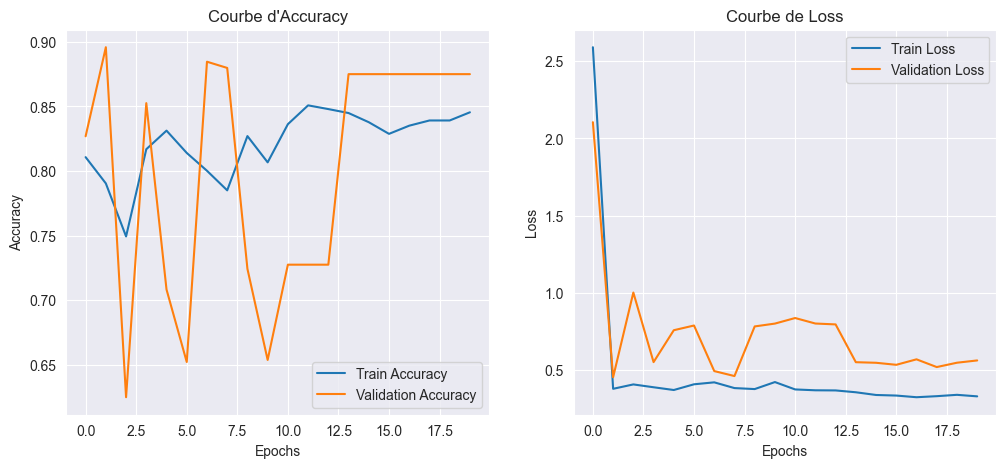

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 142ms/step


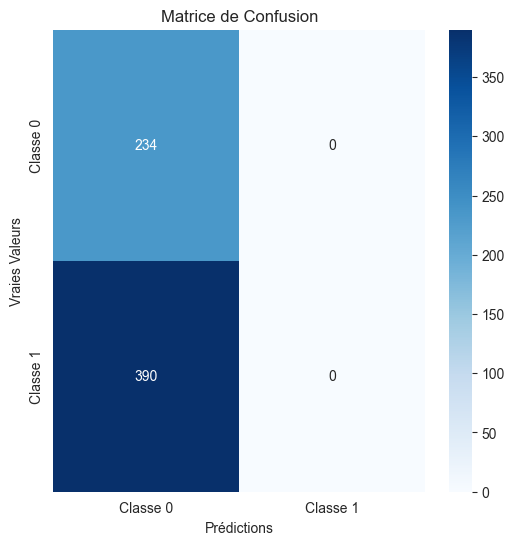

Meilleure pr√©cision atteinte : 0.8958
Perte minimale atteinte : 0.4553


In [27]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# D√©finition du nom de l'exp√©rience MLflow
experiment_name = "VGG16 Classifier Adaptatif test"
client = mlflow.tracking.MlflowClient()  # Cr√©ation d'un client pour interagir avec MLflow

# V√©rifier si l'exp√©rience existe d√©j√†
existing_experiments = client.search_experiments()
experiment_id = None

# Recherche d'une exp√©rience MLflow existante
for exp in existing_experiments:
    if exp.name == experiment_name:
        experiment_id = exp.experiment_id
        break

# Cr√©ation de l'exp√©rience si elle n'existe pas encore
if experiment_id is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Exp√©rience '{experiment_name}' cr√©√©e.")
else:
    print(f"Exp√©rience '{experiment_name}' existante, utilisation de l'ID {experiment_id}.")

# D√©finir l'exp√©rience active dans MLflow
mlflow.set_experiment(experiment_name)

# Param√®tres du mod√®le
epochs = 20  # Nombre total d'√©poques d'entra√Ænement
batch_size = 15  # Taille des mini-lots de donn√©es
dense_units = 128  # Nombre initial de neurones dans les couches denses
dropout_rate = 0.5  # Taux de dropout pour √©viter le sur-apprentissage
target_accuracy = 0.95  # Pr√©cision cible pour ajuster dynamiquement le mod√®le

# D√©finition du mod√®le initial bas√© sur VGG16
base_model = model_VGG16  # Chargement du mod√®le pr√©-entra√Æn√© VGG16
base_model.trainable = False  # Gel des poids du mod√®le pr√©-entra√Æn√©

# Ajout de couches au mod√®le pr√©-entra√Æn√©
x = Flatten()(base_model.output)  # Transformation des donn√©es en vecteur plat
x = Dense(dense_units, activation="relu")(x)  # Ajout d'une couche dense avec activation ReLU
x = Dropout(dropout_rate)(x)  # Ajout d'un dropout pour √©viter le sur-apprentissage
prediction = Dense(1, activation="sigmoid")(x)  # Couche de sortie pour la classification binaire
model = Model(inputs=base_model.input, outputs=prediction)  # Cr√©ation du mod√®le final

# Compilation du mod√®le avec une fonction de co√ªt et un optimiseur
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Dictionnaire pour stocker l'√©volution des performances
history_data = {"train_accuracy": [], "val_accuracy": [], "train_loss": [], "val_loss": []}

# D√©marrer l'enregistrement de l'exp√©rience MLflow
with mlflow.start_run(run_name=f"VGG16 Dynamique {epochs} epochs, {batch_size} batch"):
    for epoch in range(epochs):  # Boucle d'entra√Ænement sur plusieurs √©poques
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=batch_size, verbose=1)

        # Extraction des performances
        val_accuracy = history.history["val_accuracy"][0]  # Pr√©cision sur les donn√©es de validation
        train_accuracy = history.history["accuracy"][0]  # Pr√©cision sur les donn√©es d'entra√Ænement
        val_loss = history.history["val_loss"][0]  # Perte sur les donn√©es de validation
        train_loss = history.history["loss"][0]  # Perte sur les donn√©es d'entra√Ænement

        # Stocker les donn√©es pour les graphiques
        history_data["train_accuracy"].append(train_accuracy)
        history_data["val_accuracy"].append(val_accuracy)
        history_data["train_loss"].append(train_loss)
        history_data["val_loss"].append(val_loss)

        # Enregistrer les performances dans MLflow
        mlflow.log_metric(f"val_accuracy_epoch_{epoch+1}", val_accuracy)
        mlflow.log_metric(f"train_accuracy_epoch_{epoch+1}", train_accuracy)

        # V√©rifier si le mod√®le doit √™tre ajust√© dynamiquement
        if val_accuracy < target_accuracy:
            dense_units += 64  # Augmenter le nombre de neurones
            print(f"Ajout de neurones √† l'√©poque {epoch+1}, total neurones : {dense_units}")

            # Ajouter dynamiquement une couche
            new_layer = Dense(dense_units, activation="relu")
            dropout_layer = Dropout(dropout_rate)
            model = tf.keras.Sequential([model, new_layer, dropout_layer, Dense(1, activation="sigmoid")])
            model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

        else:
            print(f"Pr√©cision atteinte √† l'√©poque {epoch+1}, poursuite sans modification")

    # √âvaluation finale
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
    mlflow.log_metric("final_test_accuracy", test_accuracy)
    mlflow.log_metric("final_test_loss", test_loss)

    # Enregistrement du mod√®le et des param√®tres finaux
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("dense_units_final", dense_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.keras.log_model(model, "VGG16_Dynamique")

# G√©n√©ration des graphiques de performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_data["train_accuracy"], label="Train Accuracy")
plt.plot(history_data["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Courbe d'Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_data["train_loss"], label="Train Loss")
plt.plot(history_data["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbe de Loss")
plt.legend()

plt.show()

# Matrice de confusion
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Pr√©dictions")
plt.ylabel("Vraies Valeurs")
plt.title("Matrice de Confusion")
plt.show()

# Calcul des meilleures performances atteintes
max_accuracy = max(history_data["val_accuracy"])
min_loss = min(history_data["val_loss"])

print(f"Meilleure pr√©cision atteinte : {max_accuracy:.4f}")
print(f"Perte minimale atteinte : {min_loss:.4f}")

# Enregistrement des meilleures performances
mlflow.log_metric("max_validation_accuracy", max_accuracy)
mlflow.log_metric("min_validation_loss", min_loss)


In [ ]:
# √âvaluation du mod√®le sur les donn√©es de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)

# Affichage des performances sur l'ensemble de test
print(f"Loss sur les donn√©es de test : {test_loss}")
print(f"Accuracy sur les donn√©es de test : {test_accuracy}")

# Pr√©dictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Conversion des probabilit√©s en classes binaires
y_pred_classes = (y_pred > 0.9).astype("int")  # Seuil fix√© √† 0.9

# S√©lectionner uniquement les images pr√©dites comme PNEUMONIE ET qui sont r√©ellement des PNEUMONIA
indices_pneumonia = np.where((y_pred_classes == 1) & (y_test == 1))[0]

# V√©rifier si des indices_pneumonia ont √©t√© d√©tect√©s
if len(indices_pneumonia) == 0:
    print("‚ö† Aucun cas de pneumonie  d√©tect√© avec le seuil actuel.")
else:
    # M√©lange al√©atoire des indices des PNEUMONIE d√©tect√©s
    np.random.shuffle(indices_pneumonia)
    indices_a_afficher = indices_pneumonia[:9]  # S√©lectionne jusqu'√† 9 images al√©atoirement

    # Cr√©ation d'un affichage en grille 3x3 pour montrer quelques images de test et leurs pr√©dictions.
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(len(indices_a_afficher)):
        idx = indices_a_afficher[i]
        axes[i].imshow(X_test[idx])  # Affichage de l'image de test
        axes[i].axis("off")

        label = "PNEUMONIA" if y_pred_classes[idx] == 1 else "NORMAL"
        true_label = "PNEUMONIA" if y_test[idx] == 1 else "NORMAL"

        # Affichage du titre de l'image indiquant la pr√©diction et la r√©alit√©.
        axes[i].set_title(f"Pr√©dit : {label} / R√©el : {true_label}", fontsize=8)

    # Masquer les cases vides si moins de 9 images sont affich√©es
    for i in range(len(indices_a_afficher), 9):
        axes[i].axis("off")

    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# R√©cup√©rer les valeurs de l'historique
epochs = range(1, len(history.history['loss']) + 1)
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Cr√©ation du graphique
plt.figure(figsize=(10, 5))

# Courbe de la loss
plt.plot(epochs, loss, 'r-', label="Loss (train)")
plt.plot(epochs, val_loss, 'r--', label="Loss (val)")

# Courbe de l'accuracy
plt.plot(epochs, accuracy, 'b-', label="Accuracy (train)")
plt.plot(epochs, val_accuracy, 'b--', label="Accuracy (val)")

# Personnalisation du graphique
plt.xlabel("√âpoques")
plt.ylabel("Valeurs")
plt.title("√âvolution de l'accuracy et du loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Importation de la matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pr√©dictions sur les donn√©es de test
y_pred_proba = model.predict(X_test)

# Conversion des probabilit√©s en classes (si softmax ou sigmoid)
y_pred = np.argmax(y_pred_proba, axis=1)  # pour softmax multi-classes
# y_pred = (y_pred_proba > 0.5).astype(int)  # pour binaire (sigmoid)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Pr√©diction")
plt.ylabel("V√©rit√©")
plt.title("Matrice de confusion")
plt.show()

In [ ]:
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt
import numpy as np
from mlflow.models import infer_signature

# Extraction des meilleures m√©triques de l'entra√Ænement
meilleure_accuracy_train = max(history.history["accuracy"])
meilleure_accuracy_val = max(history.history["val_accuracy"])
min_loss = min(history.history["loss"])

# Initialisation du suivi MLflow
mlflow.set_experiment("VGG16 Classifier 1")

with mlflow.start_run(run_name="VGG16 Classifier"):

    # Enregistrement des hyperparam√®tres
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrement des m√©triques finales
    mlflow.log_metric("final_train_accuracy", meilleure_accuracy_train)
    mlflow.log_metric("final_val_accuracy", meilleure_accuracy_val)
    mlflow.log_metric("min_loss", min_loss)

    # Enregistrement des m√©triques par √©poque
    for epoch, acc in enumerate(history.history["accuracy"]):
        mlflow.log_metric(f"train_accuracy_epoch_{epoch+1}", acc)

    for epoch, val_acc in enumerate(history.history["val_accuracy"]):
        mlflow.log_metric(f"val_accuracy_epoch_{epoch+1}", val_acc)

    for epoch, loss in enumerate(history.history["loss"]):
        mlflow.log_metric(f"train_loss_epoch_{epoch+1}", loss)

    # Enregistrement du mod√®le
    mlflow.keras.log_model(model, "VGG16_classifier")

    # G√©n√©ration des graphiques de performance
    # Courbes de perte
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["loss"], label="Train Loss", linestyle="-", marker="s")
    plt.plot(history.history["val_loss"], label="Validation Loss", linestyle="-", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("√âvolution de la Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_plot.png")
    mlflow.log_artifact("loss_plot.png")

    # Courbes de pr√©cision
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["accuracy"], label="Train Accuracy", linestyle="--", marker="o")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linestyle="--", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("√âvolution de l'Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_plot.png")
    mlflow.log_artifact("accuracy_plot.png")

    # Graphique combin√© (accuracy et loss)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["accuracy"], label="Train Accuracy", linestyle="--", marker="o")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linestyle="--", marker="o")
    plt.plot(history.history["loss"], label="Train Loss", linestyle="-", marker="s")
    plt.plot(history.history["val_loss"], label="Validation Loss", linestyle="-", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("√âvolution de l'Accuracy et de la Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("combined_metrics.png")
    mlflow.log_artifact("combined_metrics.png")

    # Enregistrement de quelques pr√©dictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int")  # Seuil ajust√© √† 0.5

    # S√©lectionner des images pour MLflow
    for i in range(5):
        plt.imshow(X_test[i])
        plt.title(f"Pr√©dit : {y_pred_classes[i]}, R√©el : {y_test[i]}")
        plt.axis("off")
        plt.savefig(f"sample_prediction_{i}.png")
        mlflow.log_artifact(f"sample_prediction_{i}.png")


### Mise en place de ResNet50

In [28]:
import tensorflow as tf
import os
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
image_resize = 224

In [29]:
import warnings
warnings.filterwarnings("ignore")  # Ignore les warnings pour √©viter les messages inutiles dans la console.

def get_train_test(base_path: str):  # D√©finition d'une fonction qui charge et pr√©pare les images √† partir d'un dossier.
    X = []  # Liste pour stocker les images.
    y = []  # Liste pour stocker les labels.

    label_map = {"NORMAL": 0, "PNEUMONIA": 1}  # Dictionnaire associant les labels aux classes num√©riques.

    for label in os.listdir(base_path):  # Parcours des dossiers pr√©sents dans le r√©pertoire de base.
        if label not in label_map:  # V√©rifie que le dossier correspond bien √† une classe attendue
            continue  # Si le label ne fait pas partie des classes d√©finies, il est ignor√©.

        label_path = os.path.join(base_path, label)  # Cr√©ation du chemin vers le dossier contenant les images.

        for file_name in os.listdir(label_path):  # Parcours de chaque fichier dans le dossier.
            file_path = os.path.join(label_path, file_name)  # Obtention du chemin complet de l'image.
            img = cv2.imread(file_path)  # Lecture de l'image avec OpenCV.
            if img is None:  # V√©rifie que l'image a bien √©t√© charg√©e.
                continue  # Ignore les fichiers qui ne sont pas des images valides.

            img = cv2.resize(img, (image_resize, image_resize), interpolation=cv2.INTER_CUBIC)  # Redimensionne l'image √† la taille souhait√©e.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertit l'image du format BGR (OpenCV) √† RGB (standard).
            img = img / 255.0  # Normalise les pixels entre 0 et 1 pour am√©liorer la stabilit√© du mod√®le.

            X.append(img)  # Ajoute l'image pr√©trait√©e √† la liste X.
            y.append(label_map[label])  # Ajoute le label correspondant √† la liste y.

    X = np.array(X).reshape(-1, image_resize, image_resize, 3)  # Convertit la liste en tableau NumPy avec la bonne forme (nombre d'images, hauteur, largeur, canaux).
    y = np.array(y).reshape(-1, 1)  # Convertit la liste de labels en tableau NumPy.

    return X, y  # Retourne les tableaux contenant les images et leurs labels.

# Chargement des donn√©es d'entra√Ænement et de test.
X_train, y_train = get_train_test("chest_xray/train")  # Charge les images pour l'entra√Ænement.
X_test, y_test = get_train_test("chest_xray/test")  # Charge les images pour le test.

In [30]:
# Charger le mod√®le pr√©-entra√Æn√© sans les couches de classification finales
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Geler les couches du mod√®le de base pour conserver les poids pr√©-entra√Æn√©s
for layer in base_model.layers:
    layer.trainable = False  # On emp√™che leur entra√Ænement pour √©viter d‚Äô√©craser les connaissances acquises


In [31]:
# Ajout de couches personnalis√©es sur le mod√®le pr√©-entra√Æn√©
x = GlobalAveragePooling2D()(base_model.output)  # Permet de r√©duire la dimension tout en conservant les informations essentielles
x = Dense(512, activation="relu")(x)  # Couche dense avec activation ReLU pour capter des caract√©ristiques complexes
x = Dropout(0.3)(x)  # Dropout pour r√©duire l'overfitting
x = Dense(256, activation="relu")(x)  # Autre couche dense pour approfondir la repr√©sentation
x = Dropout(0.3)(x)  # Nouveau dropout pour plus de r√©gularisation
x = Dense(128, activation="relu")(x)  # Couche plus petite pour affiner la structure
x = Dropout(0.2)(x)  # Derni√®re r√©gularisation pour √©viter le sur-apprentissage
output = Dense(1, activation="sigmoid")(x)  # Activation sigmo√Øde pour une classification binaire

# D√©finition du mod√®le final
model = Model(inputs=base_model.input, outputs=output)

In [32]:
# D√©finition de l'optimiseur et de la fonction de perte
optimizer = Adam(learning_rate=0.0005)  # Taux d'apprentissage faible pour assurer une convergence stable
loss_function = "binary_crossentropy"  # Perte adapt√©e √† un probl√®me de classification binaire

# Compilation du mod√®le
model.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])

Exp√©rience 'ResNet50 test 1' existante, utilisation de l'ID 787516386502175654.
Epoch 1/40
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 33s 137ms/step - accuracy: 0.6685 - loss: 0.7328 - val_accuracy: 0.6250 - val_loss: 0.6818
Epoch 2/40
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 101ms/step - accuracy: 0.7186 - loss: 0.5641 - val_accuracy: 0.6330 - val_loss: 0.6156
Epoch 3/40
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 103ms/step - accuracy: 0.7757 - loss: 0.4865 - val_accuracy: 0.6651 - val_loss: 0.6043
Epoch 4/40
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 102ms/step - accuracy: 0.7987 - loss: 0.4337 - val_accuracy: 0.7420 - val_loss: 0.5038
Epoch 5/40
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 102ms/step - accuracy: 0.7962 - loss: 0.4266 - val_accuracy: 0.7115 - val_loss: 0.5270
Epoch 6/40
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

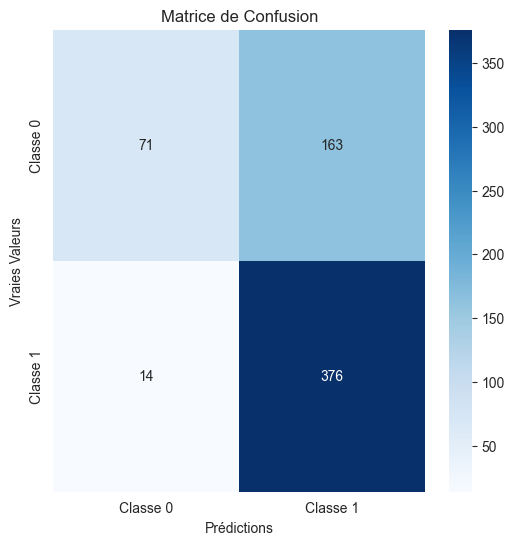

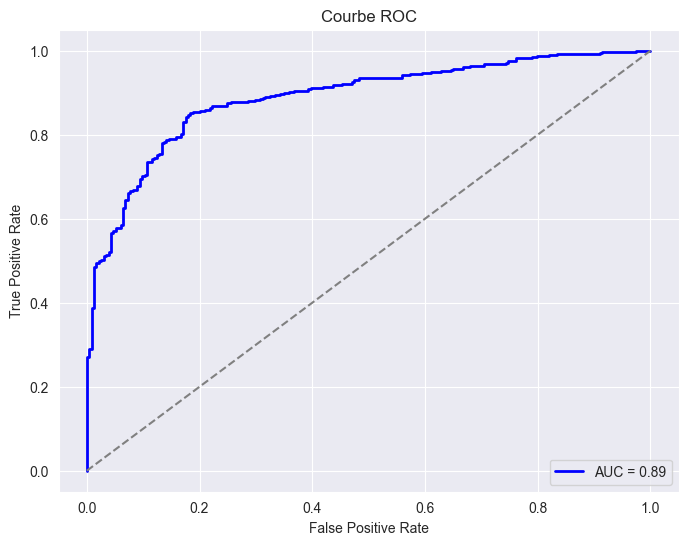

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

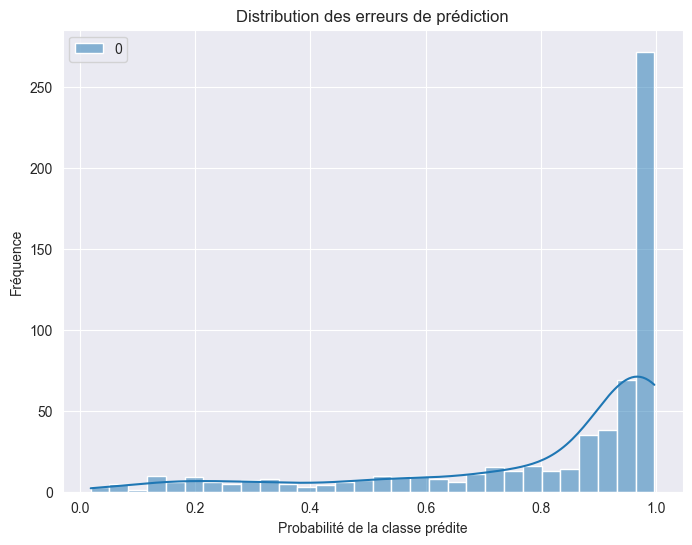

<Figure size 640x480 with 0 Axes>

2025/05/27 09:52:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/27 09:52:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Mod√®le ResNet50 √©valu√© et r√©sultats enregistr√©s dans MLflow.


In [34]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

# Nom de l'exp√©rience
experiment_name = "ResNet50 test 1"
client = mlflow.tracking.MlflowClient()

# V√©rifier si l'exp√©rience existe d√©j√†
existing_experiments = client.search_experiments()
experiment_id = None

for exp in existing_experiments:
    if exp.name == experiment_name:
        experiment_id = exp.experiment_id
        break

# Si l'exp√©rience n'existe pas, la cr√©er
if experiment_id is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Exp√©rience '{experiment_name}' cr√©√©e.")
else:
    print(f"Exp√©rience '{experiment_name}' existante, utilisation de l'ID {experiment_id}.")

# D√©finir l'exp√©rience active
mlflow.set_experiment(experiment_name)

# Chargement du mod√®le ResNet50 pr√©-entra√Æn√©
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
prediction = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# √âvaluation du mod√®le sur les donn√©es de test
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)

# R√©cup√©ration des valeurs maximales et minimales
max_accuracy = max(history.history["val_accuracy"])
min_loss = min(history.history["val_loss"])

# Pr√©dictions sur le jeu de test
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_prob = model.predict(X_test)

# Calcul des m√©triques avanc√©es
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# **Ajout de mlflow.end_run() pour √©viter les conflits**
mlflow.end_run()

# Sauvegarde des m√©triques dans MLflow
with mlflow.start_run(run_name="R√©sultats Test ResNet50"):
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("max_validation_accuracy", max_accuracy)
    mlflow.log_metric("min_validation_loss", min_loss)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc_roc", roc_auc)

# Matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Pr√©dictions")
plt.ylabel("Vraies Valeurs")
plt.title("Matrice de Confusion")
mlflow.log_figure(plt.figure(1), "conf_matrix.png")
plt.show()

# Courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
mlflow.log_figure(plt.figure(2), "roc_curve.png")
plt.show()

# Courbe de pr√©cision et rappel
plt.figure(figsize=(8, 6))
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Pr√©cision & Perte")
plt.legend()
mlflow.log_figure(plt.figure(3), "precision_loss_curve.png")
plt.show()

# Courbe du F1-score
plt.figure(figsize=(8, 6))
plt.plot(range(len(history.history["val_accuracy"])), [f1] * len(history.history["val_accuracy"]), label="F1-score", color="green")
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.title("√âvolution du F1-score")
plt.legend()
mlflow.log_figure(plt.figure(4), "f1_score_curve.png")
plt.show()

# Distribution des erreurs de pr√©diction
plt.figure(figsize=(8, 6))
sns.histplot(y_prob, bins=30, kde=True, color="blue")
plt.xlabel("Probabilit√© de la classe pr√©dite")
plt.ylabel("Fr√©quence")
plt.title("Distribution des erreurs de pr√©diction")
mlflow.log_figure(plt.figure(5), "error_distribution.png")
plt.show()

# Sauvegarde du mod√®le
mlflow.keras.log_model(model, "ResNet50_Test")

print("Mod√®le ResNet50 √©valu√© et r√©sultats enregistr√©s dans MLflow.")


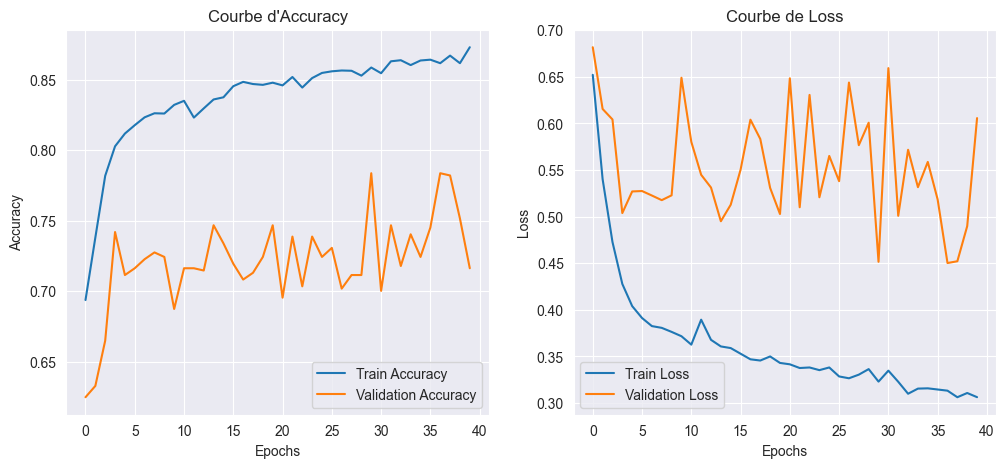

In [35]:
import matplotlib.pyplot as plt

# R√©cup√©ration des valeurs d'accuracy et de loss
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Cr√©ation des graphiques
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Courbe d'Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Courbe de Loss")

# Affichage des graphiques
plt.show()

10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 293ms/step - accuracy: 0.8830 - loss: 0.2638
Loss sur les donn√©es de test : 0.605775773525238
Accuracy sur les donn√©es de test : 0.7163461446762085
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 113ms/step


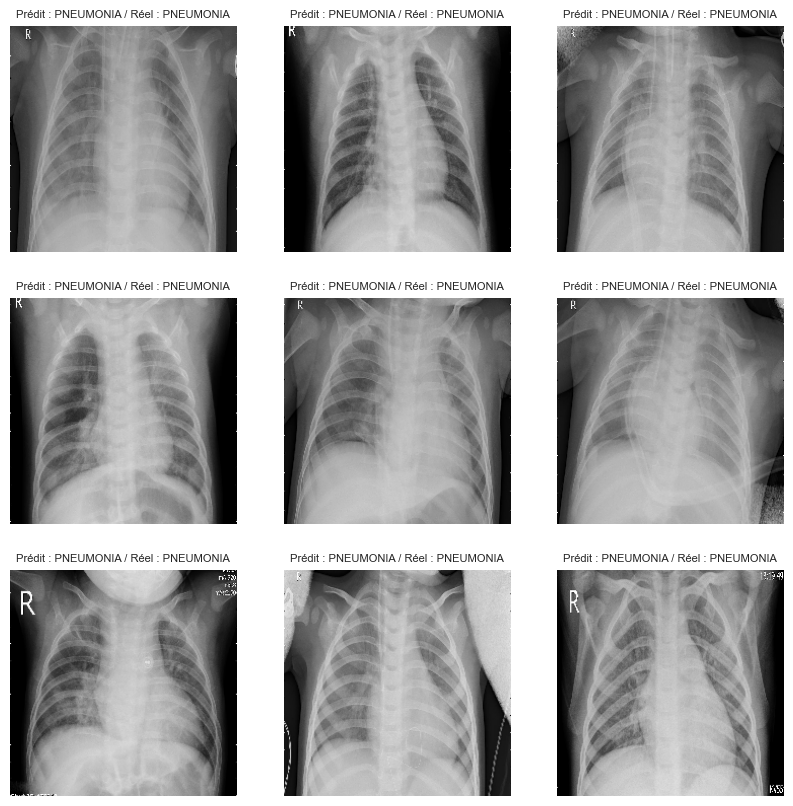

In [36]:
# √âvaluation du mod√®le sur les donn√©es de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)

# Affichage des performances sur l'ensemble de test
print(f"Loss sur les donn√©es de test : {test_loss}")
print(f"Accuracy sur les donn√©es de test : {test_accuracy}")

# Pr√©dictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Conversion des probabilit√©s en classes binaires
y_pred_classes = (y_pred > 0.9).astype("int")  # Seuil fix√© √† 0.9

# S√©lectionner uniquement les images pr√©dites comme PNEUMONIE ET qui sont r√©ellement des PNEUMONIA
indices_pneumonia = np.where((y_pred_classes == 1) & (y_test == 1))[0]

# V√©rifier si des indices_pneumonia ont √©t√© d√©tect√©s
if len(indices_pneumonia) == 0:
    print("‚ö† Aucun cas de pneumonie  d√©tect√© avec le seuil actuel.")
else:
    # M√©lange al√©atoire des indices des PNEUMONIE d√©tect√©s
    np.random.shuffle(indices_pneumonia)
    indices_a_afficher = indices_pneumonia[:9]  # S√©lectionne jusqu'√† 9 images al√©atoirement

    # Cr√©ation d'un affichage en grille 3x3 pour montrer quelques images de test et leurs pr√©dictions.
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(len(indices_a_afficher)):
        idx = indices_a_afficher[i]
        axes[i].imshow(X_test[idx])  # Affichage de l'image de test
        axes[i].axis("off")

        label = "PNEUMONIA" if y_pred_classes[idx] == 1 else "NORMAL"
        true_label = "PNEUMONIA" if y_test[idx] == 1 else "NORMAL"

        # Affichage du titre de l'image indiquant la pr√©diction et la r√©alit√©.
        axes[i].set_title(f"Pr√©dit : {label} / R√©el : {true_label}", fontsize=8)

    # Masquer les cases vides si moins de 9 images sont affich√©es
    for i in range(len(indices_a_afficher), 9):
        axes[i].axis("off")

    plt.show()


##### mod√®le Xception

In [37]:
#Import Os and Basis Libraries
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [38]:
# Directory containing the "Train" folder
directory = "chest_xray/train"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [ ]:
df_train

In [39]:
# Directory containing the "Train" folder
directory = "chest_xray/test"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [40]:
df_test.sample(5)

filepath      label
65   chest_xray/test/PNEUMONIA/person74_virus_135.jpeg  PNEUMONIA
265   chest_xray/test/PNEUMONIA/person30_virus_69.jpeg  PNEUMONIA
507   chest_xray/test/NORMAL/NORMAL2-IM-0251-0001.jpeg     NORMAL
211  chest_xray/test/PNEUMONIA/person131_bacteria_6...  PNEUMONIA
253  chest_xray/test/PNEUMONIA/person121_bacteria_5...  PNEUMONIA

In [41]:
print(f"The shape of The Train data is: {df_train.shape}")
print(f"The shape of The Test data is: {df_test.shape}")

The shape of The Train data is: (5216, 2)
The shape of The Test data is: (624, 2)


In [42]:
data_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

IMAGE_SIZE = (256,256)

print('Training Images:')
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

#Testing  Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Training Images:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Validation Images:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


In [43]:
# Extraction des noms de classes depuis les ensembles de donn√©es
train_labels = train_ds.class_names  # √âtiquettes des donn√©es d'entra√Ænement
test_labels = test_ds.class_names  # √âtiquettes des donn√©es de test
validation_labels = validation_ds.class_names  # √âtiquettes des donn√©es de validation

# Encodage des √©tiquettes

# D√©finition des classes pr√©sentes dans l'ensemble de donn√©es
class_labels = ['NORMAL', 'PNEUMONIA']  # Deux cat√©gories : cas normaux et cas de pneumonie

# Instanciation du encodeur de labels
label_encoder = LabelEncoder()  # Outil permettant de convertir les √©tiquettes textuelles en valeurs num√©riques

# Entra√Ænement de l'encodeur sur les classes d√©finies
label_encoder.fit(class_labels)

# Transformation des √©tiquettes en valeurs num√©riques pour l'ensemble d'entra√Ænement
train_labels_encoded = label_encoder.transform(train_labels)

# Transformation des √©tiquettes en valeurs num√©riques pour l'ensemble de validation
validation_labels_encoded = label_encoder.transform(validation_labels)

# Transformation des √©tiquettes en valeurs num√©riques pour l'ensemble de test
test_labels_encoded = label_encoder.transform(test_labels)


In [44]:
# Boucle sur les lots d'images et leurs √©tiquettes dans l'ensemble d'entra√Ænement
for image_batch, labels_batch in train_ds:
    # Affichage de la forme du batch d'images
    print("Shape of X_train: ", image_batch.shape)  # Donne la structure du lot d'images
    # Affichage de la forme du batch d'√©tiquettes
    print("Shape of y_train: ", labels_batch.shape)  # Donne la structure des √©tiquettes associ√©es
    break  # Arr√™te la boucle apr√®s le premier lot


Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


In [45]:
# Normalisation des images dans l'ensemble d'entra√Ænement
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))

# Normalisation des images dans l'ensemble de validation
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

# Normalisation des images dans l'ensemble de test
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

In [46]:
# Comptage du nombre d'occurrences de chaque cat√©gorie dans la colonne 'label' du dataframe d'entra√Ænement
count = df_train['label'].value_counts()

# Cr√©ation d'une figure contenant deux sous-graphiques (pie chart et bar chart)
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# D√©finition d'une palette de couleurs pour les graphiques
palette = sns.color_palette("viridis")  # S√©lectionne une palette de couleurs "viridis"
sns.set_palette(palette)  # Applique cette palette aux visualisations Seaborn

# Cr√©ation d'un diagramme circulaire (pie chart) sur le premier sous-graphique
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution des Cat√©gories')  # Titre du graphique

# Cr√©ation d'un diagramme en barres sur le deuxi√®me sous-graphique
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Nombre d‚Äô√©chantillons par cat√©gorie')  # Titre du graphique

# Ajustement automatique de la disposition des sous-graphiques pour √©viter les chevauchements
plt.tight_layout()

# Affichage des graphiques
plt.show()

In [47]:
# Comptage du nombre d'occurrences de chaque cat√©gorie dans la colonne 'label' du dataframe de test
count = df_test['label'].value_counts()

# Cr√©ation d'une figure contenant deux sous-graphiques (pie chart et bar chart)
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')  # Deux sous-graphiques c√¥te √† c√¥te

# D√©finition d'une palette de couleurs pour les graphiques
palette = sns.color_palette("viridis")  # Utilisation de la palette "viridis"
sns.set_palette(palette)  # Application de cette palette aux visualisations Seaborn

# Cr√©ation d'un diagramme circulaire (pie chart) sur le premier sous-graphique
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)  # Ajout des pourcentages
axs[0].set_title('Distribution par Cat√©gories')  # Titre du graphique

# Cr√©ation d'un diagramme en barres sur le deuxi√®me sous-graphique
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")  # Affichage du nombre d'occurrences
axs[1].set_title('Nombre d‚Äô√©chantillons par cat√©gorie')  # Titre du graphique

# Ajustement automatique de la disposition des sous-graphiques pour √©viter les chevauchements
plt.tight_layout()

# Affichage des graphiques
plt.show()

In [48]:
def visualize_images(path, num_images=5):
    """
    Fonction pour afficher un certain nombre d'images d'un dossier sp√©cifi√©.

    :param path: Chemin du dossier contenant les images.
    :param num_images: Nombre d'images √† afficher (par d√©faut 5).
    """

    # Obtenir la liste des fichiers d'images dans le dossier sp√©cifi√©
    image_filenames = os.listdir(path)

    # Limiter le nombre d'images √† afficher si le dossier en contient moins que num_images
    num_images = min(num_images, len(image_filenames))

    # Cr√©ation d'une figure avec plusieurs sous-plots pour afficher les images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Boucle pour parcourir les images s√©lectionn√©es et les afficher
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Construction du chemin complet de l'image
        image_path = os.path.join(path, image_filename)

        # Chargement de l'image avec Matplotlib
        image = mpimg.imread(image_path)

        # Affichage de l'image
        axes[i].imshow(image)  # Afficher l'image
        axes[i].axis('off')  # D√©sactiver l'affichage des axes
        axes[i].set_title(image_filename)  # D√©finir le nom du fichier comme titre

    # Ajustement automatique de la disposition pour √©viter les chevauchements
    plt.tight_layout()

    # Affichage de la figure
    plt.show()

In [49]:
#### Images Normal sans pneumonie
path_to_visualize = "chest_xray/train/NORMAL"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

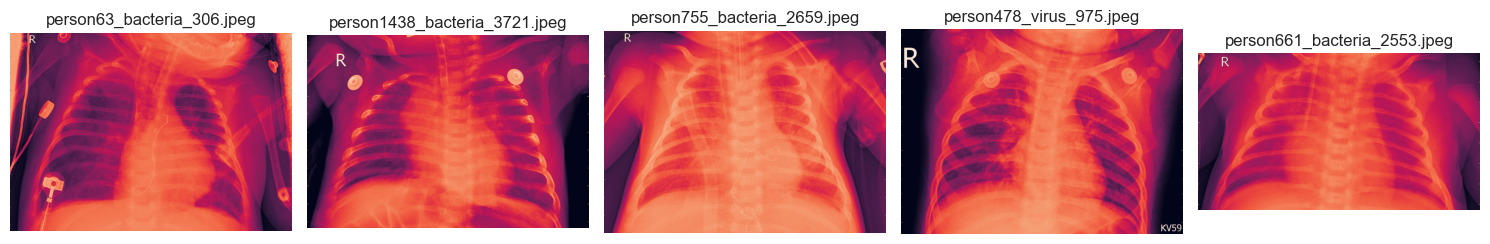

In [50]:
#### Images Pneumonia avec pneumonie
path_to_visualize = "chest_xray/train/PNEUMONIA"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [51]:
# Importation du mod√®le Xception pr√©-entra√Æn√© depuis Keras
from keras.src.applications.xception import Xception

# Chargement du mod√®le Xception sans la couche de classification finale (include_top=False)
# - weights='imagenet' : Utilise les poids pr√©-entra√Æn√©s sur ImageNet
# - include_top=False : Supprime les couches finales de classification pour permettre la personnalisation
# - pooling='avg' : Ajoute un pooling global afin de r√©duire la taille des features extraites
# - input_shape=(256, 256, 3) : Sp√©cifie la taille des images en entr√©e (256x256, avec 3 canaux RVB)
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

# Geler les couches du mod√®le pr√©-entra√Æn√© pour √©viter de modifier ses poids durant l'apprentissage
base_model.trainable = False

# Construction du mod√®le personnalis√©
model = Sequential()

# Ajout du mod√®le Xception comme base du mod√®le
model.add(base_model)

# Ajout d'une couche de normalisation pour stabiliser l'entra√Ænement
model.add(BatchNormalization())

# Ajout d'une couche de dropout (probabilit√© de d√©sactivation de 45%)
model.add(Dropout(0.45))

# Ajout d'une premi√®re couche dense (220 neurones, activation ReLU)
model.add(Dense(220, activation='relu'))

# Ajout d'une seconde couche de dropout pour √©viter le sur-apprentissage
model.add(Dropout(0.25))

# Ajout d'une deuxi√®me couche dense (60 neurones, activation ReLU)
model.add(Dense(60, activation='relu'))

# Ajout de la couche de sortie avec activation sigmo√Øde pour classification binaire
model.add(Dense(1, activation='sigmoid'))

# Compilation du mod√®le
# - Optimiseur : Adamax avec un taux d'apprentissage de 0.001 (adaptatif et stable)
# - Fonction de perte : binary_crossentropy (adapt√©e aux probl√®mes de classification binaire)
# - M√©trique : pr√©cision ('accuracy') pour suivre la performance
model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du r√©sum√© du mod√®le : architecture et nombre de param√®tres entra√Ænables
model.summary()

Model: "sequential_35"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ xception (Functional)           ‚îÇ (None, 2048)           ‚îÇ    20,861,480 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_4           ‚îÇ (None, 2048)           ‚îÇ         8,192 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_42 (Dropout)            ‚îÇ (None, 2048)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_83 (Dense)                ‚îÇ (None, 220)            ‚îÇ       450,780 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_43 (Dropout)            ‚îÇ (None, 220)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_84 (Dense)                ‚îÇ (None, 60)             ‚îÇ        13,260 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_85 (Dense)                ‚îÇ (None, 1)              ‚îÇ            61 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 21,333,773 (81.38 MB)

 Trainable params: 468,197 (1.79 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

‚úÖ Exp√©rience 'Xception Classifier Extension' existante, utilisation de l'ID 995093069502134072.
Epoch 1/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 49s 224ms/step - accuracy: 0.8219 - loss: 0.5518 - val_accuracy: 0.9290 - val_loss: 0.1650
Epoch 2/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 28s 189ms/step - accuracy: 0.9010 - loss: 0.2838 - val_accuracy: 0.9539 - val_loss: 0.1042
Epoch 3/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 184ms/step - accuracy: 0.9049 - loss: 0.3025 - val_accuracy: 0.9674 - val_loss: 0.0764
Epoch 4/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 184ms/step - accuracy: 0.9212 - loss: 0.2353 - val_accuracy: 0.9578 - val_loss: 0.0905
Epoch 5/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 185ms/step - accuracy: 0.9224 - loss: 0.2442 - val_accuracy: 0.9616 - val_loss: 0.0925
Epoch 6/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

2025-05-27 11:55:46.810968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 265ms/step
17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 145ms/step


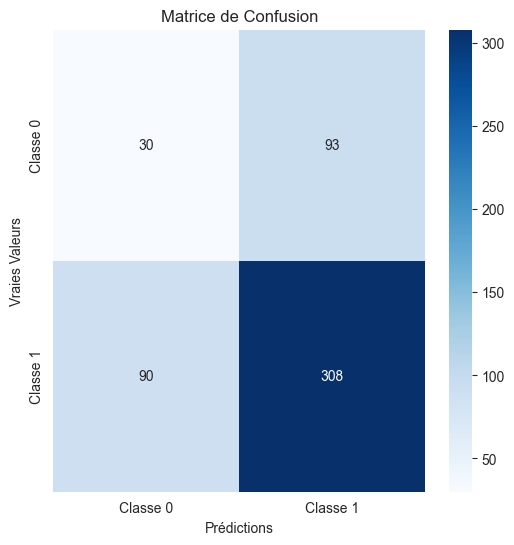

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

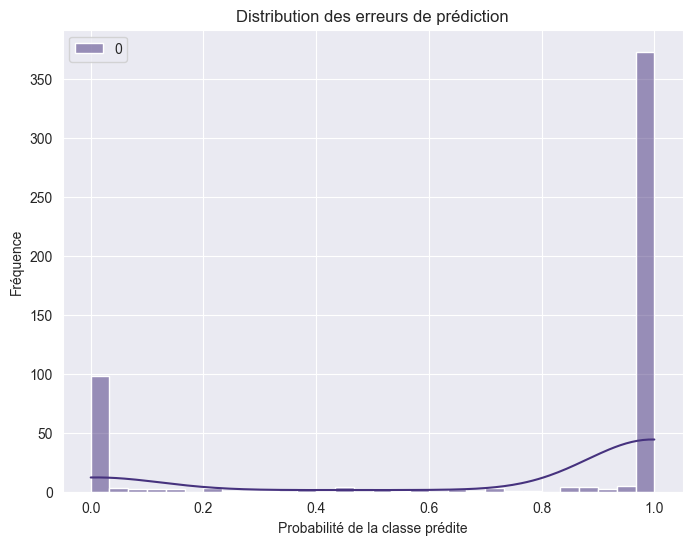

<Figure size 640x480 with 0 Axes>

2025/05/27 11:55:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/27 11:56:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÜ Meilleure pr√©cision atteinte : 0.9827
üìâ Perte minimale atteinte : 0.0595


In [60]:
# Importation des biblioth√®ques n√©cessaires
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from keras.src.applications.xception import Xception

# D√©finition du nom de l'exp√©rience MLflow
experiment_name = "Xception Classifier Extension"
client = mlflow.tracking.MlflowClient()

# V√©rification si l'exp√©rience existe d√©j√†
existing_experiments = client.search_experiments()
experiment_id = None

for exp in existing_experiments:
    if exp.name == experiment_name:
        experiment_id = exp.experiment_id
        break

# Cr√©ation de l'exp√©rience si elle n'existe pas
if experiment_id is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"üÜï Exp√©rience '{experiment_name}' cr√©√©e.")
else:
    print(f"‚úÖ Exp√©rience '{experiment_name}' existante, utilisation de l'ID {experiment_id}.")

# D√©finir l'exp√©rience active dans MLflow
mlflow.set_experiment(experiment_name)

# Param√®tres du mod√®le
epochs = 20
batch_size = 15
dense_units = 220
dropout_rate = 0.45
learning_rate = 0.001

# Chargement du mod√®le Xception pr√©-entra√Æn√©
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))
base_model.trainable = False

# Construction du mod√®le
model = Sequential([
    base_model,
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(dense_units, activation='relu'),
    Dropout(0.25),
    Dense(60, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation du mod√®le
model.compile(optimizer=Adamax(learning_rate=learning_rate), loss='binary_crossentropy', metrics=["accuracy"])

# D√©finition d'un m√©canisme d'arr√™t anticip√©
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# **Ajout de mlflow.end_run() pour √©viter les conflits**
mlflow.end_run()

# Enregistrement de l'exp√©rience MLflow
with mlflow.start_run(run_name="R√©sultats Test Xception Extension"):
    history = model.fit(
        train_ds,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_ds,
        callbacks=[early_stopping],
        verbose=1
    )

    test_loss, test_accuracy = model.evaluate(validation_ds, batch_size=batch_size)

    max_accuracy = max(history.history["val_accuracy"])
    min_loss = min(history.history["val_loss"])

    # Extraction correcte des vraies √©tiquettes du jeu de validation
    true_labels = np.concatenate([y.numpy() for _, y in validation_ds], axis=0)

    # Pr√©dictions sur le jeu de test
    y_pred = (model.predict(validation_ds) > 0.5).astype("int32")
    y_prob = model.predict(validation_ds)

    # Calcul des m√©triques avanc√©es
    precision = precision_score(true_labels, y_pred)
    recall = recall_score(true_labels, y_pred)
    f1 = f1_score(true_labels, y_pred)

    # Courbe ROC
    fpr, tpr, _ = roc_curve(true_labels, y_prob)
    roc_auc = auc(fpr, tpr)

    # Sauvegarde des m√©triques dans MLflow
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("max_validation_accuracy", max_accuracy)
    mlflow.log_metric("min_validation_loss", min_loss)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc_roc", roc_auc)

    # Matrice de confusion
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix(true_labels, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
    plt.xlabel("Pr√©dictions")
    plt.ylabel("Vraies Valeurs")
    plt.title("Matrice de Confusion")
    mlflow.log_figure(plt.figure(1), "conf_matrix.png")
    plt.show()

    # Courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Courbe ROC")
    plt.legend(loc="lower right")
    mlflow.log_figure(plt.figure(2), "roc_curve.png")
    plt.show()

    # Courbe de pr√©cision et rappel
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="blue")
    plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Pr√©cision & Perte")
    plt.legend()
    mlflow.log_figure(plt.figure(3), "precision_loss_curve.png")
    plt.show()

    # Courbe du F1-score
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(history.history["val_accuracy"])), [f1] * len(history.history["val_accuracy"]), label="F1-score", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("F1-score")
    plt.title("√âvolution du F1-score")
    plt.legend()
    mlflow.log_figure(plt.figure(4), "f1_score_curve.png")
    plt.show()

    # Distribution des erreurs de pr√©diction
    plt.figure(figsize=(8, 6))
    sns.histplot(y_prob, bins=30, kde=True, color="blue")
    plt.xlabel("Probabilit√© de la classe pr√©dite")
    plt.ylabel("Fr√©quence")
    plt.title("Distribution des erreurs de pr√©diction")
    mlflow.log_figure(plt.figure(5), "error_distribution.png")
    plt.show()

    # Sauvegarde du mod√®le
    mlflow.keras.log_model(model, "Xception_Extension")

# R√©cup√©ration des valeurs maximales et minimales
max_accuracy = max(history.history["val_accuracy"])
min_loss = min(history.history["val_loss"])

# Sauvegarde des m√©triques dans MLflow
mlflow.log_metric("max_validation_accuracy", max_accuracy)
mlflow.log_metric("min_validation_loss", min_loss)

# Affichage des r√©sultats
print(f"üèÜ Meilleure pr√©cision atteinte : {max_accuracy:.4f}")
print(f"üìâ Perte minimale atteinte : {min_loss:.4f}")

In [61]:
# √âvaluation des performances du mod√®le sur l'ensemble de validation
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Affichage de la perte et de la pr√©cision obtenues sur l'ensemble de validation
print("Validation Loss:", validation_loss)  # Affiche la perte (erreur du mod√®le)
print("Validation Accuracy:", validation_accuracy)  # Affiche la pr√©cision de classification

17/17 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 149ms/step - accuracy: 0.9796 - loss: 0.0467
Validation Loss: 0.05946784093976021
Validation Accuracy: 0.9788867831230164


In [62]:
# √âvaluation du mod√®le sur le dataset de test
test_loss, test_accuracy = model.evaluate(test_ds)

# Affichage des r√©sultats en pourcentage
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 180ms/step - accuracy: 0.8232 - loss: 0.6588
Test Loss: 0.7615131735801697
Test Accuracy: 81.57%


In [63]:
# Trouver le num√©ro de la meilleure √©poque (epoch) o√π la pr√©cision de validation est maximale
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# D√©finir le style de fond pour les graphiques
plt.style.use('ggplot')  # Utilisation d'un style valide pour matplotlib

# Cr√©ation d'une figure avec 2 sous-graphiques (subplots)
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# üìä Trac√© de la pr√©cision (accuracy) en entra√Ænement et en validation
axs[0].plot(history.history['accuracy'], label='Pr√©cision Entra√Ænement', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Pr√©cision Validation', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green',
               label=f'Meilleure √©poque : {best_epoch}')  # Marquage du meilleur epoch
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Pr√©cision')
axs[0].set_title('Pr√©cision en entra√Ænement et validation')
axs[0].legend()  # Affichage de la l√©gende

# üìâ Trac√© de la perte (loss) en entra√Ænement et en validation
axs[1].plot(history.history['loss'], label='Perte Entra√Ænement', color='blue')
axs[1].plot(history.history['val_loss'], label='Perte Validation', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',
               label=f'Meilleure √©poque : {best_epoch}')  # Marquage du meilleur epoch
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perte')
axs[1].set_title('Perte en entra√Ænement et validation')
axs[1].legend()  # Affichage de la l√©gende

# üìè Ajustement de la mise en page pour √©viter le chevauchement
plt.tight_layout()

# üñºÔ∏è Affichage du graphique final
plt.show()


In [64]:
# D√©finition du chemin vers le dossier contenant les images de test
test_dir = 'chest_xray/test/'
print('Chargement des images de test...')

# Chargement du dataset d'images depuis le dossier sp√©cifi√©
# - `seed=123` assure que les images sont toujours charg√©es dans le m√™me ordre
# - `image_size=IMAGE_SIZE` redimensionne toutes les images √† la taille souhait√©e
# - `batch_size=32` d√©finit le nombre d'images trait√©es simultan√©ment
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(256, 256),  # Assurez-vous que IMAGE_SIZE est bien d√©fini
    batch_size=32
)

# D√©finition d'une fonction pour afficher les images avec leurs pr√©dictions
def plot_images_with_predictions(model, dataset, class_labels, num_images=20, num_images_per_row=5):
    """
    Cette fonction affiche un ensemble d'images avec leur **classe r√©elle** et **classe pr√©dite**.
    Elle prend :
    - `model` : Le mod√®le de deep learning entra√Æn√©
    - `dataset` : Le dataset contenant les images √† pr√©dire
    - `class_labels` : Les noms des classes (ex: ['NORMAL', 'PNEUMONIA'])
    - `num_images` : Le nombre total d'images √† afficher
    - `num_images_per_row` : Nombre d'images par ligne pour la mise en forme
    """

    # V√©rifier que le dataset contient suffisamment d'images
    dataset_list = list(dataset.as_numpy_iterator())  # Convertir le dataset en liste
    if len(dataset_list) == 0:
        print("Erreur : le dataset est vide !")
        return

    # M√©lange le dataset pour √©viter l'ordre fixe
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset_list))

    # G√©n√©ration des pr√©dictions
    predictions = model.predict(dataset_shuffled.take(num_images))

    # Cr√©ation de la figure pour afficher les images
    plt.figure(figsize=(15, 10))

    img_counter = 0  # Compteur pour suivre le nombre d'images affich√©es

    for images, labels in dataset_shuffled.take(num_images):
        images = images.numpy()  # Convertir Tensor en NumPy

        for j in range(len(images)):  # Parcours des images dans le batch
            if img_counter < num_images:  # S'assurer que l'on ne d√©passe pas le nombre d'images souhait√©
                predicted_class = class_labels[np.argmax(predictions[img_counter])]
                true_class = class_labels[np.argmax(labels[j])]

                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, img_counter + 1)
                plt.imshow(images[j].astype("uint8"))
                plt.title(f'R√©el: {true_class}\nPr√©dit: {predicted_class}')
                plt.axis('off')

                img_counter += 1  # Incr√©menter le compteur

    plt.tight_layout()
    plt.show()

# Affichage des images avec leurs pr√©dictions
print('Affichage des pr√©dictions sur 20 images al√©atoires du dataset de test...')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)


Chargement des images de test...
Found 624 files belonging to 2 classes.
Affichage des pr√©dictions sur 20 images al√©atoires du dataset de test...


2025-05-27 12:05:22.701496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 192ms/step


2025-05-27 12:05:27.407886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [65]:
# D√©finition du chemin du dossier contenant les images de test
directory_path = 'chest_xray/test/PNEUMONIA/'

# S√©lectionner les N premi√®res images du dossier (ici, 5 images)
image_files = os.listdir(directory_path)[:5]

# Cr√©ation d'une figure avec plusieurs sous-graphiques pour afficher les images
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))  # Une ligne avec autant d'images que s√©lectionn√©es

# Boucle pour charger, pr√©traiter et pr√©dire les images s√©lectionn√©es
for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)  # Construction du chemin complet de l'image

    # Chargement de l'image avec OpenCV
    img = cv2.imread(img_path)

    # Redimensionnement de l'image √† la taille requise par le mod√®le (256x256 pixels)
    img = cv2.resize(img, (256, 256))

    # Normalisation des valeurs des pixels pour les mettre entre 0 et 1
    img_array = img.astype(np.float32) / 255.0

    # Expansion des dimensions pour correspondre aux attentes du mod√®le (ajout d'une dimension batch)
    img_array = np.expand_dims(img_array, axis=0)

    # Faire une pr√©diction avec le mod√®le entra√Æn√©
    predictions = model.predict(img_array)

    # Convertir la sortie du mod√®le en une classe (0 = Normal, 1 = Pneumonie)
    actual_prediction = (predictions > 0.5).astype(int)

    # Affichage de l'image avec l'√©tiquette pr√©dite
    # Conversion de l'image de BGR (format OpenCV) √† RGB pour un affichage correct avec Matplotlib
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')  # Suppression des axes pour une meilleure lisibilit√©

    # D√©finition du titre de l'image selon la pr√©diction du mod√®le
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Pr√©diction : {predicted_label}')

# Ajustement automatique de la disposition des sous-graphiques
plt.tight_layout()

# Affichage final des images avec leurs pr√©dictions
plt.show()

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 62ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 35ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 23ms/step
